In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import earthpy as et
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import box

from utils.drapp import (
    save_shapefile, save_tiles, get_utm_zone_from_bbox, plot_aoi_bbox,
    merge_tiles, plot_rgb_image, crop_geotiff
)
from utils.segment_drapp import (
    generate_binary_gdf, plot_binary_gdf, multipolygons_to_polygons,
    classless_multipolygons_to_polygons, calculate_area, apply_buffer,
    get_bounds_gdf, bin_plot, plot_gdf, generate_binary_gdf_ndvi
)

# MODIFY THIS LINE TO CHANGE THE STUDY AREA
STUDY_AREA = "AOI002"

DATA_DIR = os.path.join(et.io.HOME, et.io.DATA_NAME, 'treebeard')
DRAPP_DIR = os.path.join(DATA_DIR, 'drapp_tile_scheme_2020')
DRAPP_TILES_DIR = os.path.join(DATA_DIR, 'drapp_tiles')
BUFFER_SIZE = 5 # feet
MERGE_PATH = f'./scratch/{STUDY_AREA}_merged.tif'
BBOX_CROP_PATH = f"./scratch/{STUDY_AREA}_cropped_bbox.tif"
AOI_CROP_PATH = f"./scratch/{STUDY_AREA}_cropped_aoi.tif"
QUICKSHIFT_PATH = f"./scratch/{STUDY_AREA}_quickshift.png"
SEGMENT_PATH = f"./scratch/{STUDY_AREA}_segmented.png"
PREBUFFER_PATH = f"./scratch/{STUDY_AREA}_prebuffer.png"
BUFFER_PATH = f"./scratch/{STUDY_AREA}_buffer.png"
OUTPUT_PATH = f"./scratch/{STUDY_AREA}_final_openspace.shp"

# MODIFY THIS DICTIONARY TO ADD NEW STUDY AREAS
AOI_SHAPEFILES = {
    "AOI001": 'assets/areas/immediate_project/Zumwinkel_property.shp', # 5 mins
    "AOI002": 'assets/areas/planning/Potential Project Area_1.shp', # 10+ mins
    "AOI003": 'assets/areas/planning/Potential Project Area.shp', # 5 mins
    "AOI004": 'assets/areas/planning/ProjectOverview.shp' # 10+ hour?
}

In [2]:
study_area = AOI_SHAPEFILES.get(STUDY_AREA)
aoi_gdf = gpd.read_file(study_area)
if len(aoi_gdf) > 1:
    if 'Potential Project Area_1.shp' in study_area:
        aoi_gdf = aoi_gdf.head(2)
    elif 'Potential Project Area.shp' in study_area:
        # the last item
        aoi_gdf = aoi_gdf.tail(1)
    aoi_gdf = aoi_gdf.dissolve()
if not aoi_gdf.crs or aoi_gdf.crs.to_epsg() != 4326:
    aoi_gdf.to_crs(epsg=4326, inplace=True)

In [3]:
# Find bounding box of AOI
bbox_aoi_gdf = gpd.GeoDataFrame(
    geometry=aoi_gdf.bounds.apply(
        lambda row: box(
            row['minx'], row['miny'], 
            row['maxx'], row['maxy']), axis=1))
bbox_aoi_gdf.crs = aoi_gdf.crs
bbox_aoi = bbox_aoi_gdf.unary_union.bounds

# Download DRAPP shapefile
drapp_shapefile = save_shapefile(DRAPP_DIR)
# Load DRAPP shapefile
drapp_gdf = gpd.read_file(drapp_shapefile)
drapp_gdf = drapp_gdf.to_crs(aoi_gdf.crs) # EPSG:6428 -> EPSG:4326
# Spatial join to find intersecting DRAPP tiles
# drapp_aoi_gdf = gpd.sjoin(drapp_gdf, aoi_gdf, how='inner', predicate='intersects')
drapp_aoi_gdf = gpd.sjoin(drapp_gdf, bbox_aoi_gdf, how='inner', predicate='intersects')

In [4]:
utm_zone, epsg_code = get_utm_zone_from_bbox(bbox_aoi)
print(f"UTM Zone: {utm_zone}, {epsg_code}")

UTM Zone: 13, EPSG:32613


In [5]:
# Create a plot with AOI, bounding box, and DRAPP tiles
fig_aoi = plot_aoi_bbox(aoi_gdf, bbox_aoi_gdf, drapp_aoi_gdf)
fig_aoi.show()

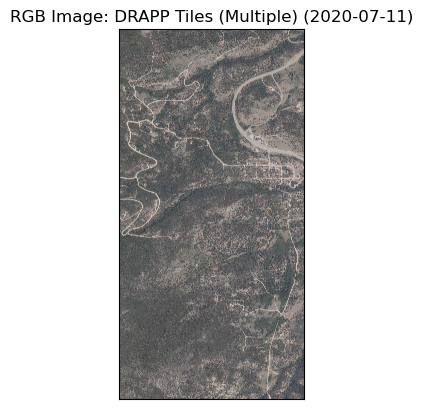

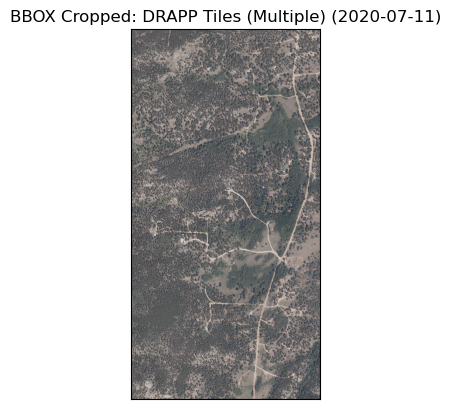

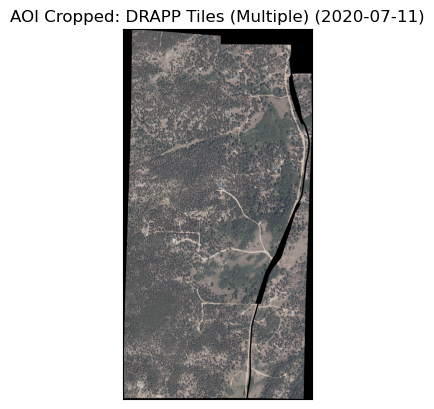

In [6]:
# Save DRAPP tiles
drapp_tilenames = list(drapp_aoi_gdf['tile'].unique())
drapp_tilepaths = save_tiles(DRAPP_TILES_DIR, drapp_tilenames)

# Merge DRAPP tiles into one
merged_tile_path = merge_tiles(drapp_tilepaths, MERGE_PATH)
plot_rgb_image(merged_tile_path, drapp_aoi_gdf, save_png_file=True)

# Define crop path and crop merged tile to AOI BBOX
cropped_geotiff = crop_geotiff(merged_tile_path, bbox_aoi_gdf, BBOX_CROP_PATH)
plot_rgb_image(cropped_geotiff, drapp_aoi_gdf, title_prefix='BBOX Cropped:', save_png_file=True)

# Crop to AOI
cropped_geotiff = crop_geotiff(merged_tile_path, aoi_gdf, AOI_CROP_PATH)
plot_rgb_image(cropped_geotiff, drapp_aoi_gdf, title_prefix='AOI Cropped:', save_png_file=True)

In [7]:
# Check raster crs
# Expecting EPSG:6428
with rasterio.open(cropped_geotiff) as src:
    print(src.crs)

EPSG:6428


In [21]:
BBOX_CROP_PATH

'./scratch/AOI002_cropped_bbox.tif'

Quickshift number of segments: 53430


Converting segments to vector features: 59971it [00:01, 37340.66it/s]
Dissolving polygons by class: 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]


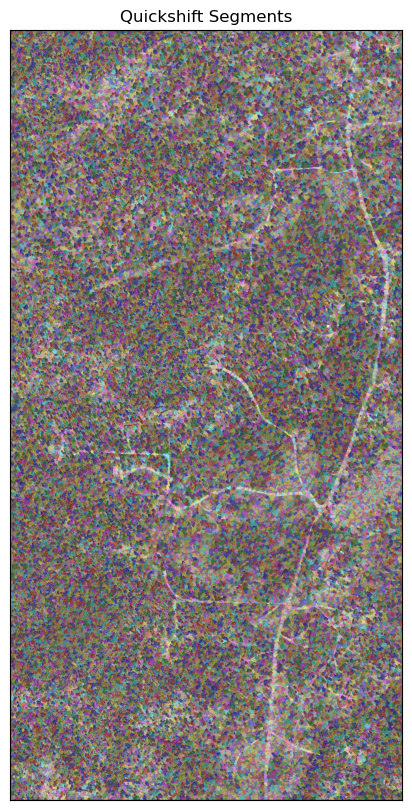

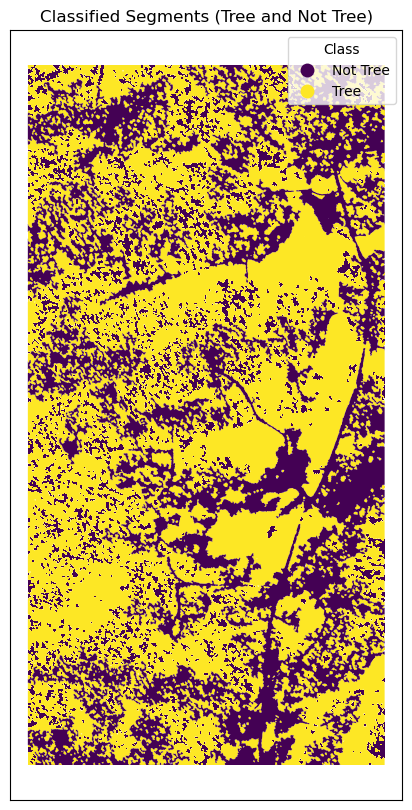

<Figure size 640x480 with 0 Axes>

In [8]:
# dissolved_gdf = generate_binary_gdf(BBOX_CROP_PATH)
dissolved_gdf = generate_binary_gdf_ndvi(BBOX_CROP_PATH, plot_segments=True, plot_path=QUICKSHIFT_PATH)
plot_binary_gdf(dissolved_gdf, filepath=SEGMENT_PATH, save_png_file=True)

In [9]:
# Convert multipolygons to polygons
polygons_gdf = multipolygons_to_polygons(dissolved_gdf)

# Calculate areas
polygons_gdf = calculate_area(polygons_gdf)

# Create dataframes for openspace and canopy
openspace_gdf = polygons_gdf[polygons_gdf['class'] == 0]
canopy_gdf = polygons_gdf[polygons_gdf['class'] == 1]

In [10]:
# Define bins and labels
# The first bin will be [0, 1/8)
# The second bin will be [1/8, 1/4)
# The third bin will be [1/4, 1/2)
# The fourth bin will be [1/2, 1)
# The fifth bin will be [1, ∞)
bins = [0, 1/8, 1/4, 1/2, 1, float('inf')]  # Added infinity to cover areas larger than 1 acre
labels = ['< 1/8 acre', '1/8 - <1/4 acre', '1/4 - <1/2 acre', '1/2 - <1 acre', '>= 1 acre']

In [11]:
bounds_gdf = get_bounds_gdf(BBOX_CROP_PATH)

In [12]:
b_canopy_gdf, b_openspace_gdf = apply_buffer(canopy_gdf, bounds_gdf, BUFFER_SIZE)

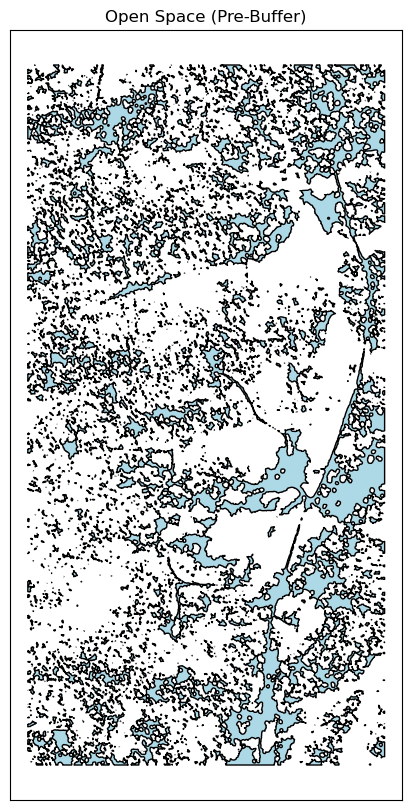

<Figure size 640x480 with 0 Axes>

In [13]:
plot_gdf(b_openspace_gdf, 'Open Space (Pre-Buffer)', PREBUFFER_PATH, save_png_file=True)

In [14]:
final_openspace_gdf = classless_multipolygons_to_polygons(b_openspace_gdf)
final_openspace_gdf = calculate_area(final_openspace_gdf)

In [15]:
# reproject match (aoi_gdf to final_openspace_gdf)
# 4326 -> 6428
# Crop the final openspace to the AOI
# final_openspace_gdf = final_openspace_gdf.to_crs(aoi_gdf.crs)
aoi_gdf = aoi_gdf.to_crs(final_openspace_gdf.crs)
final_openspace_gdf = gpd.overlay(final_openspace_gdf, aoi_gdf, how='intersection')

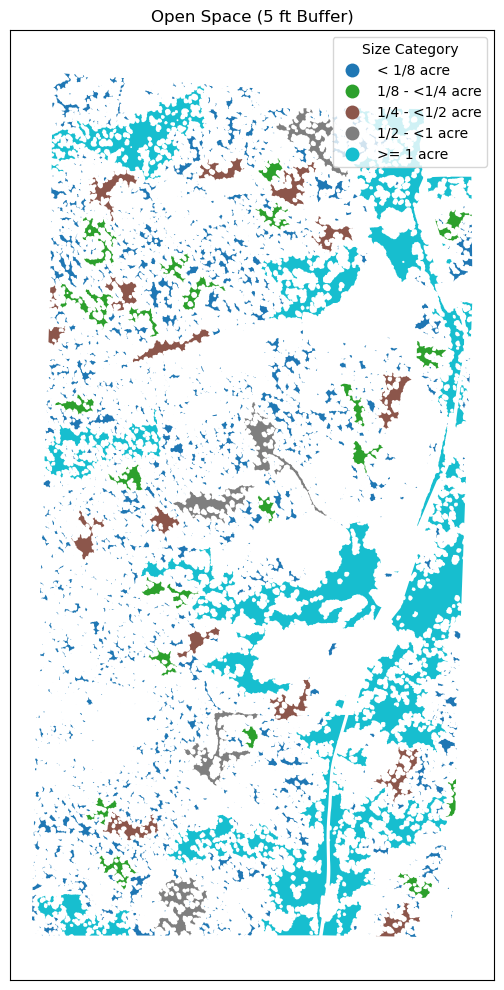

<Figure size 640x480 with 0 Axes>

In [16]:
bin_plot(final_openspace_gdf, bins, 
         labels, f"Open Space ({BUFFER_SIZE} ft Buffer)",
         BUFFER_PATH, save_png_file=True)

In [17]:
final_openspace_gdf['bin'] = final_openspace_gdf['bin'].astype(str)
final_openspace_gdf.to_file(OUTPUT_PATH)

In [ ]:
final_openspace_gdf

In [18]:
# Verify projection is in 6428
final_openspace_gdf.crs

<Projected CRS: EPSG:6428>
Name: NAD83(2011) / Colorado Central (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich